# Procesamiento de Imágenes - Trabajo Práctico N°1
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

## Ejercicio 5
Se desea decimar la imagen “mono.bmp” que se encuentra en el sitio de la materia. Para ello, se pide:

1. Dividir la imagen en bloques de 4x4 pixeles, y quedarse con el pixel en la posición (2,2).
2. Repetir la decimación tomando el pixel en la posición (1,1).
3. Repetir tomando el promedio de los 16 puntos.
4. Interpolar las imágenes obtenidas en los tres puntos anteriores para obtener una imagen de la resolución original utilizando interpolación bilineal y bicúbica. Implementar las interpolaciones a mano.
5. Graficar el espectro de la imagen original. Obtener conclusiones.

## Resolución

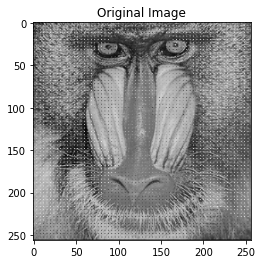

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Open bitmap and cast to numpy array
original_image = np.array(Image.open('../consigna/mono.bmp'))

# Plot original image
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.show()

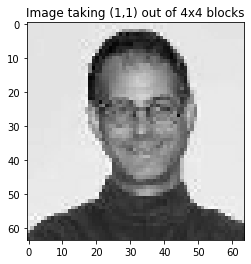

In [2]:
image_1_1 = original_image[0::4,0::4]
plt.title('Image taking (1,1) out of 4x4 blocks')
plt.imshow(image_1_1, cmap='gray')

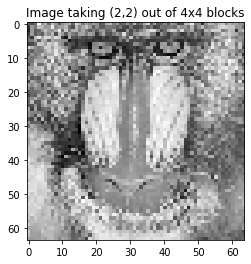

In [3]:
image_2_2 = original_image[1::4,1::4]
plt.title('Image taking (2,2) out of 4x4 blocks')
plt.imshow(image_2_2, cmap='gray')

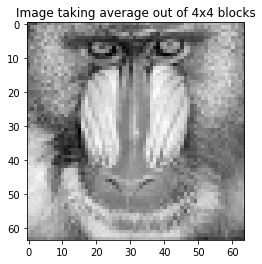

In [4]:
image_avg = np.array([[int(original_image[i:i+4, j:j+4].mean()) for j in range(0,255,4)] for i in range(0,255,4)])
plt.title('Image taking average out of 4x4 blocks')
plt.imshow(image_avg, cmap='gray')

# Interpolación Bicúbica
La interpolación bicúbica nace de extender la interpolación cúbica a dos dimensiones. Dado que una interpolación cúbica requiere de cuatro puntos para obtener la función de aproximación, la interpolación bicúbica requerirá contar con la información de los dieciseis pixeles más cercanos a la zona de interés, formando un cuadrado alrededor de esta zona. De esta forma, se logra escalar una imagen a un tamaño mayor.


<div style="text-align:center"><img src="assets/ej5/bicubic_diagram.png" width="400"></div>


El proceso comienza con un padding (llevado a cabo por la función *image_padding* detallada abajo), de forma tal de completar dos filas/columnas con el valor de la última fila/columna de la imagen. Se realiza el mismo procedimiento con las esquinas resultantes. Luego, para cada pixel en la imagen escalada se traduce la posición del mismo en la imagen original, arrojando un valor decimal. Se obtiene la posición del pixel de referencia (a11 en la imagen) computando la parte entera de las coordenadas que surgieron del escalamiento. Una vez obtenido este pixel equivalente, se buscan los 15 píxeles adyacentes restantes y para cada uno se calculan las distancias al pixel escalado original. Este método de interpolación pondera la información de estos 16 píxeles adyacentes evaluando la distancia al píxel original en la siguiente función, denominada *función bicúbica*.

$$W(s)= \left\{ \begin{array}{lcc}
             (a+2)|s|^3-(a+3)|s|^2+1 &   si  & |x| \leq 1 \\
             \\a|s|^3-5a|s|^2+8a|s|-4a &  si & 1 < |x| < 2 \\
             \\ 0 &  otherwise
             \end{array}
   \right.$$
   
Empleando la función anterior se calcula el peso considerando la distancia en el eje x y en el eje y, y se computa el peso total como el producto de estos. Para obtener el valor de intensidad del pixel interpolado, se realiza la suma ponderada del valor de cada uno de los 16 píxeles adyacentes de referencia, como se muestra en la siguiente ecuación.

$$p(x,y) = \sum_{i=0}^3 \sum_{j=0}^3 a_{ij} \cdot W(i) \cdot W(j)$$

Donde $a_{ij}$ es el valor de intensidad del pixel resultante y $W(i)$ y $W(j)$ son los pesos calculados en base a la distancia en x e y, respectivamente.

In [5]:
# Padding funcion (Monochromatic)
def image_padding(img, padding_size=2, padding_same=True):
    # Get image height and width
    h, w = img.shape
    ps = padding_size
    
    # Create new image with padding (adding 2*ps rows and 2*ps cols)
    pad_img = np.zeros((h+2*ps, w+2*ps))
    
    # Copy image, centered
    pad_img[ps:h+ps, ps:w+ps] = img
    
    if padding_same == True :
        # Extending image rows/cols to padding
        
        # Padding top
        pad_img[0:ps, ps:w+ps] = img[0, :]
        # Padding bottom
        pad_img[h+ps:h+2*ps, ps:w+ps] = img[h - 1, :]
        # Padding right
        pad_img[ps:h+ps, w+ps:w+2*ps] = np.array([[x] for x in img[:, w - 1]])
        # Padding left
        pad_img[ps:h+ps, 0:ps] = np.array([[x] for x in img[:, 0]])
        
        # Padding top-right corner
        pad_img[0:ps, w+ps:w+2*ps] = img[0, w - 1]
        # Padding bottom-right corner
        pad_img[h+ps:h+2*ps, w+ps:w+2*ps] = img[h - 1, w - 1]
        # Padding bottom-left corner
        pad_img[h+ps:h+2*ps, 0:ps] = img[h - 1, 0]
        # Padding top-left corner
        pad_img[0:ps, 0:ps] = img[0,0]
        
    return pad_img

In [6]:
# Bicubic function
# Returns the bicubic 1D weight of a given pixel. 
def bic_w(s, a=-0.5):

    x = np.abs(s)
    
    if (x < 1):
        w = (a+2)*(x**3) - (a+3)*(x**2) + 1
        
    elif (x >= 1) and (x < 2):
        w = a*(x**3) - 5*a*(x**2) + 8*a*x - 4*a
    
    else:
        w = 0
        
    return w
    
# Bicubic interpolation function
# Scales an image using bicubic interpolation. 
def bicubic_interpolation(img, ratio=2, a=-0.5, padding_same=True):
    dh, dw = map(int, np.array(img.shape) * ratio)
    k = dh / img.shape[0]
    
    # Destination image padding
    pad_img = image_padding(img=img, padding_size=2, padding_same=padding_same)
    
    # Destination image buffer
    dest = np.zeros((dh, dw)) 
    
    # Iterate over every pixel in destination image
    for i in range(dh):
        for j in range(dw):
            
            # Scale large image coords to fit source ones (+2 padding offset)
            x = (j / k) + 2
            y = (i / k) + 2
            
            # Get adjacent columns coords (in small image)
            x1 = int(np.floor(x) - 1)
            x2 = x1 + 1
            x3 = x1 + 2
            x4 = x1 + 3
            
            # Get adjacent rows coords (in small image)
            y1 = int(np.floor(y) - 1)
            y2 = y1 + 1
            y3 = y1 + 2
            y4 = y1 + 3
            
            # Get weight matrix
            A = np.matrix([[bic_w(x-x1, a), bic_w(x-x2, a), bic_w(x-x3, a), bic_w(x-x4, a)]])
            
            # Get pixel value matrix
            B = np.matrix([
                            [pad_img[y1,x1], pad_img[y2,x1], pad_img[y3,x1], pad_img[y4,x1]],
                            [pad_img[y1,x2], pad_img[y2,x2], pad_img[y3,x2], pad_img[y4,x2]],
                            [pad_img[y1,x3], pad_img[y2,x3], pad_img[y3,x3], pad_img[y4,x3]],
                            [pad_img[y1,x4], pad_img[y2,x4], pad_img[y3,x4], pad_img[y4,x4]]
                
                        ])
            
            C = np.matrix([
                            [bic_w(y-y1, a)],
                            [bic_w(y-y2, a)],
                            [bic_w(y-y3, a)],
                            [bic_w(y-y4, a)]
                
                        ])
            
            dest[i, j] = np.dot(np.dot(A,B),C)
            
    return dest

# Interpolación Bilineal

Para agrandar una imagen por un factor de escala, utilizando una interpolación bilineal, se utiliza para cada pixel nuevo en la imagen de salida el promedio ponderado de los cuatro pixeles más cercanos al mismo. Para ubicar los pixeles más cercanos, se proyecta la posición del nuevo pixel, sobre la imagen original, tomando la posicón relativa del mismo y multiplicando por el alto y ancho de la imaegen original. Finalmente se ponderan los mismos en función de la distancia al nuevo pixel.

Utilizando este método se debe prestar atención a los pixeles de la ultima fila o la ultima columna ya que los mismos requerien de pixeles que exceden el tamaño de la imagen original, por ello en la implementación presentada a continuación se agranda la imagen en 1 pixel en todas las direcciones copiando los datos de los extremos de la misma, otra alternativa seria agrandar la imagen y completar con 0 el borde, lo cual generaría en la imagen resultante bordes mas oscuros.

In [7]:
# Blinear interpolation function
# Scales an image using bilinear interpolation.
def bilinear_interpolation(img, ratio=2, padding_same=True):
    dh, dw = map(int, np.array(img.shape) * ratio)
    k = dh / img.shape[0]
    
    # Create a copy of the original image with padding
    pad_img = image_padding(img=img, padding_size=1, padding_same=padding_same)
    
    # Create a buffer for the output image
    dest = np.zeros((dh, dw)) 
 
    # Iterate over all the pixels of the new image and iterpolate
    for i in range(dh):
        for j in range(dw):
            x = i / k + 1
            y = j / k + 1
 
            x1, y1 = int(x), int(y)
            x2, y2 = x1    , y1 + 1
            x3, y3 = x1 + 1, y1
            x4, y4 = x1 + 1, y1 + 1

            # Get the distance from the "theorical" point to the top-left pixel
            u = x - x1
            v = y - y1
 
            # Interpolación (is splited for better clarity...)
            temp = (1-u)*(1-v)*pad_img[x1, y1] + (1-u)* v * pad_img[x2, y2] 
            temp +=   u *(1-v)*pad_img[x3, y3] +    u * v * pad_img[x4, y4]
            
            dest[i, j] = int(temp)
            
    return dest


Wall time: 718 ms


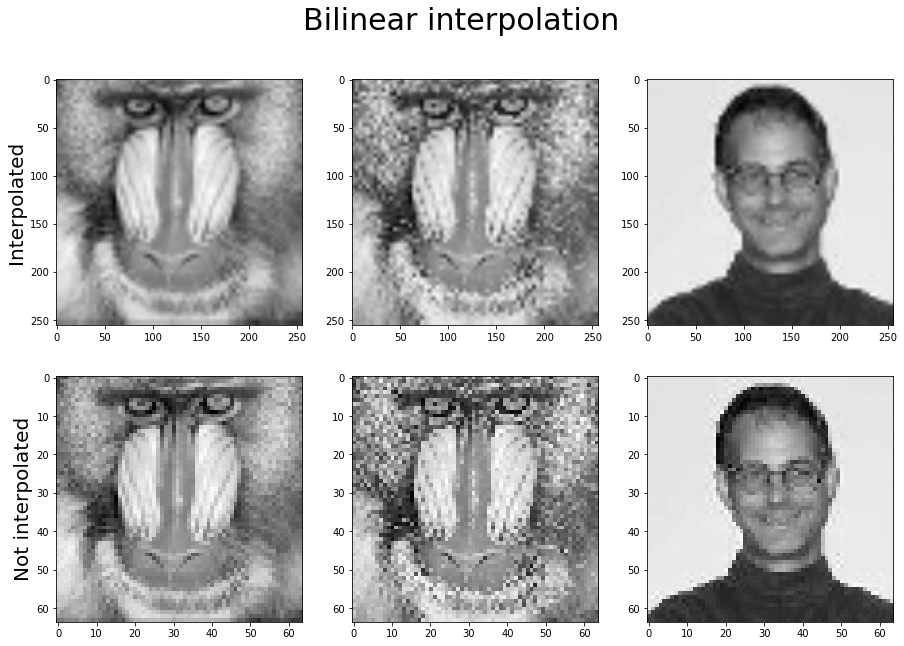

In [22]:
%%time
scaling_factor = original_image.shape[0] / image_avg.shape[0]
image_avg_up_bl = bilinear_interpolation(image_avg, ratio=scaling_factor)
image_2_2_up_bl = bilinear_interpolation(image_2_2, ratio=scaling_factor)
image_1_1_up_bl = bilinear_interpolation(image_1_1, ratio=scaling_factor)

fig, axs = plt.subplots(2,3, figsize=(15,10))
fig.suptitle('Bilinear interpolation', fontsize=30)

axs[0,0].set_ylabel('Interpolated', fontsize=20)
axs[1,0].set_ylabel('Not interpolated', fontsize=20)

axs[0,0].imshow(image_avg_up_bl, cmap='gray')
axs[0,1].imshow(image_2_2_up_bl, cmap='gray')
axs[0,2].imshow(image_1_1_up_bl, cmap='gray')

axs[1,0].imshow(image_avg, cmap='gray')
axs[1,1].imshow(image_2_2, cmap='gray')
axs[1,2].imshow(image_1_1, cmap='gray')


Wall time: 18.6 s


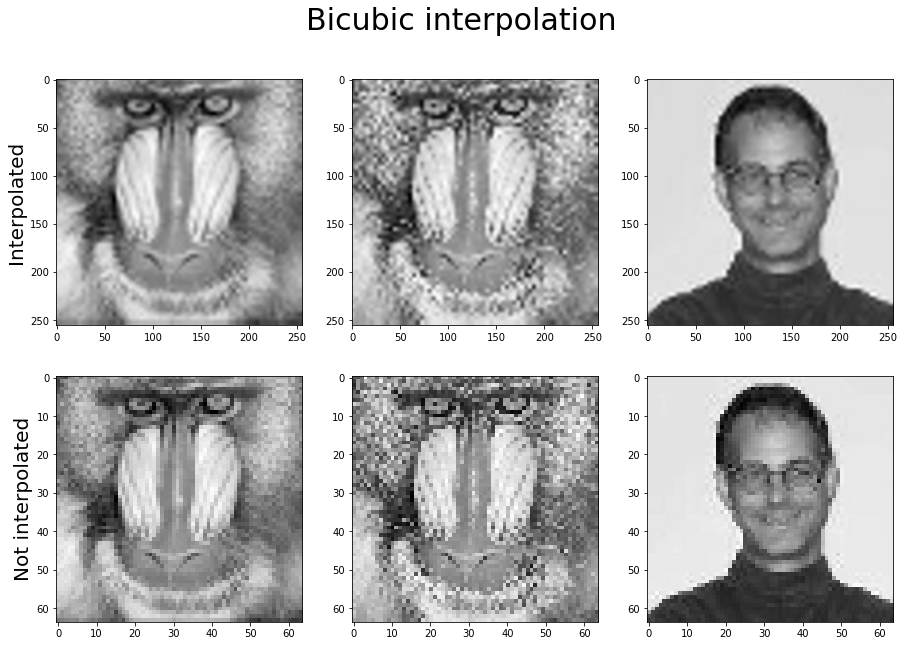

In [24]:
%%time
scaling_factor = original_image.shape[0] / image_avg.shape[0]
image_avg_up_bc = bicubic_interpolation(image_avg, ratio=scaling_factor)
image_2_2_up_bc = bicubic_interpolation(image_2_2, ratio=scaling_factor)
image_1_1_up_bc = bicubic_interpolation(image_1_1, ratio=scaling_factor)

fig, axs = plt.subplots(2,3, figsize=(15,10))
fig.suptitle('Bicubic interpolation', fontsize=30)

axs[0,0].set_ylabel('Interpolated', fontsize=20)
axs[1,0].set_ylabel('Not interpolated', fontsize=20)

axs[0,0].imshow(image_avg_up_bc, cmap='gray')
axs[0,1].imshow(image_2_2_up_bc, cmap='gray')
axs[0,2].imshow(image_1_1_up_bc, cmap='gray')

axs[1,0].imshow(image_avg, cmap='gray')
axs[1,1].imshow(image_2_2, cmap='gray')
axs[1,2].imshow(image_1_1, cmap='gray')

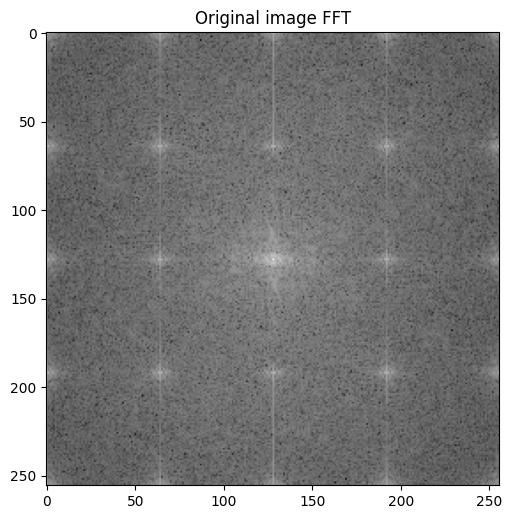

In [10]:
# Using fftshift to shift zero freq to center
image_fft =np.fft.fftshift(np.fft.fft2(original_image))
# Using log scale
plt.figure(num=None, figsize=(8, 6), dpi=100)
plt.imshow(np.log10(abs(image_fft)), cmap='gray')
plt.title('Original image FFT')
plt.show()

En el gráfico anterior se reproduce la FFT de la imagen orginal, en donde se aprecian una serie de puntos (o zonas) de mayor intensidad respecto del resto de la imagen. Esto en principio correspondería a los puntos intercalados y equidistantes que se observan en la imagen original, que en frecuencia se pueden traducir como componentes de alta frecuencia y sus armónicos. Por otro lado, las líneas intensas verticales que conectan algunos de estos puntos implican que existen cambios de intensidad apreciables si se recorre la imagen de forma vertical.